# Counterfactuals guided by prototypes on MNIST

Code is adopted from: [alibi](https://github.com/SeldonIO/alibi/blob/e3d993369e38332022cf40f8bd4b37fb0352674f/doc/source/examples/cfproto_mnist.ipynb)

In [70]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs 
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from time import time
from tqdm import tqdm
from alibi.explainers import CounterfactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.12.1
Eager execution enabled:  False


## Load and prepare MNIST data

In [95]:
data_path = "../data/raw_data/mnist/mnist_train.csv"
data = pd.read_csv(data_path, 
                        delimiter=",", header=None, dtype=np.uint8)
X = data.iloc[:, 1:]
y = np.asarray(data.iloc[:, :1][0])

all_indices = []
for digit in np.arange(0,10):
    single_digit_indices = set(np.where(y == digit)[0][:1000])
    all_indices = set(all_indices).union(single_digit_indices)
print(len(all_indices))

X = X.iloc[list(all_indices), :]

X = X[X.columns].values.reshape(-1, 28, 28)
y = np.asarray(data.iloc[list(all_indices), :1][0])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

10000


In [96]:
print(x_train.shape)
print(y.shape)
print(y_train.shape)

(8000, 28, 28)
(10000,)
(8000,)


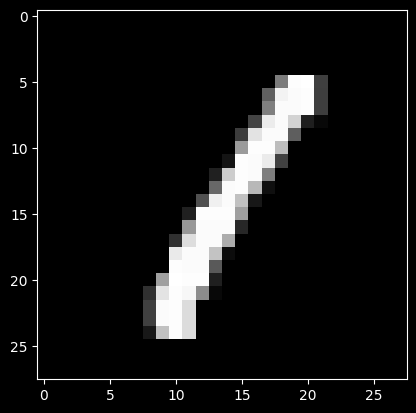

In [92]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(X[3]);

Prepare data: scale, reshape and categorize

In [97]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

X = X.astype('float32') / 255
X = np.reshape(X, X.shape + (1,))
y = to_categorical(y)
print('X shape:', X.shape, "y shape:", y.shape)

x_train shape: (8000, 28, 28, 1) x_test shape: (2000, 28, 28, 1)
y_train shape: (8000, 10) y_test shape: (2000, 10)
X shape: (10000, 28, 28, 1) y shape: (10000, 10)


In [98]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin
X = ((X - X.min()) / (X.max() - X.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [7]:
cnn = cnn_model()
cnn.fit(x_train, y_train, batch_size=32, epochs=3, verbose=0)
cnn.save('../data/saved_models/mnist_cnn.h5', save_format='h5')

KeyboardInterrupt: 

Evaluate the model on test set

In [8]:
cnn = load_model('../data/saved_models/mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

c:\Users\s3964913\Anaconda3\envs\facelift\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy:  0.98683333


In [9]:
print(x_test.shape)

(12000, 28, 28, 1)


In [10]:
cnn.predict(x_test).shape

c:\Users\s3964913\Anaconda3\envs\facelift\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(12000, 10)

## Define and train auto-encoder

In [11]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

In [18]:
# ae, enc, dec = ae_model()
# ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
# ae.save('../data/saved_models/mnist_ae.h5', save_format='h5')
# enc.save('../data/saved_models/mnist_enc.h5', save_format='h5')

## Generate counterfactual guided by the nearest class prototype

Original instance:

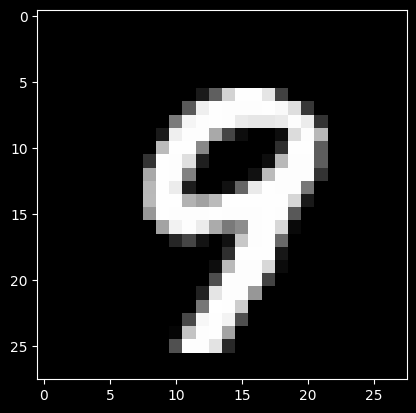

In [45]:
factual_img_idx = 0
target_class = 5
factual_x = x_train[factual_img_idx].reshape((1,) + x_test[0].shape)
plt.imshow(factual_x.reshape(28, 28));

Counterfactual parameters:

In [17]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())
ae = load_model('../data/saved_models/mnist_ae.h5')
enc = load_model('../data/saved_models/mnist_enc.h5')

Run counterfactual:

In [46]:
# initialize explainer, fit and generate counterfactual
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(factual_x, k=20, k_type='mean', target_class=[target_class])
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 2.196 sec
Explanation took 8.292 sec


Results:

In [48]:
print(explanation.cf.keys())

dict_keys(['X', 'class', 'proba', 'grads_graph', 'grads_num'])


Counterfactual prediction: 4
Closest prototype class: 4


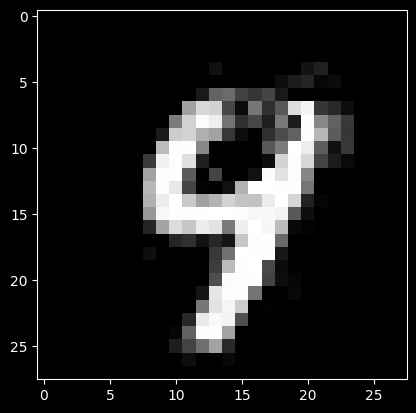

In [49]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

iteration c 0


C:\Users\s3964913\AppData\Local\Temp\ipykernel_16572\1631250178.py:3: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  n = len(explanation['all'][iter_cf])
C:\Users\s3964913\AppData\Local\Temp\ipykernel_16572\1631250178.py:7: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))


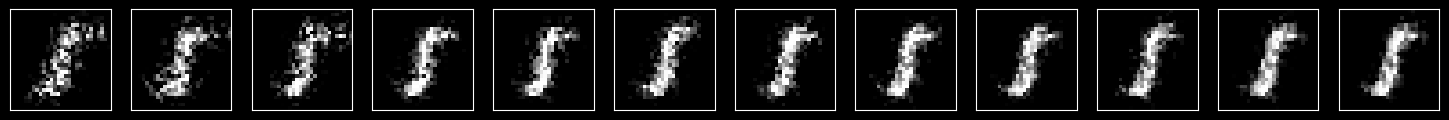

In [23]:
iter_cf = 0
print(f'iteration c {iter_cf}')
n = len(explanation['all'][iter_cf])
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n+1, i+1)
    plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [120]:
sub_one_indices = list(np.where(y[:, 1]==1)[0])[11:30]
real_inst_for_all = []
for factual_img_idx in tqdm(sub_one_indices):
    # factual_img_idx = 6
    factual_x = X[factual_img_idx].reshape((1,) + x_test[0].shape)
    # plt.imshow(factual_x.reshape(28, 28));
    all_exp_for_one = []
    real_inst_for_one = [factual_img_idx]
    for target_class in [2,3,4,5,6,7,8,9]:
        explanation = cf.explain(factual_x, k=20, k_type='mean', target_class=[target_class])
        if explanation == None:
            continue
        all_exp_for_one.append(explanation.cf["X"])
        real_cf_idx = find_closest_cf_instance(explanation.cf["X"], X, cnn, target_class)
        real_inst_for_one.append(real_cf_idx)

    real_inst_for_all.append(real_inst_for_one)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [1:41:38<00:00, 320.99s/it]


In [130]:
import pickle

# with open("proto_solutions.pickle", "wb") as inter_data_file:
#     pickle.dump(real_inst_for_all, inter_data_file)

In [105]:
# Find the nearest real counterfactual instance from the dataset (from the 10000 datasets)

def find_closest_cf_instance(cf_point, dataset, predictor, cf_class):
    min_dist = 785
    closest_cf_id = None
    reshaped_cf_point = cf_point.reshape(-1)

    for idx, point in enumerate(dataset):
        point = point.reshape(1, 28, 28, 1)
        prediction = np.argmax(predictor.predict(point))
        if prediction == cf_class:
            reshaped_point = point.reshape(-1)
            dist = np.linalg.norm((reshaped_cf_point - reshaped_point), ord=1)
            if dist < min_dist:
                min_dist = dist
                closest_cf_id = idx
    
    assert closest_cf_id != None, ("No counterfactual found")
    return closest_cf_id

cf_img = explanation.cf["X"]  #.reshape(-1)  # reshape from (1, 28, 28, 1) to (784,)
print(cf_img.shape)
x_all = np.concatenate([x_train, x_test], axis=0)

real_cf_idx = find_closest_cf_instance(cf_img, X, cnn, target_class)

(1, 28, 28, 1)


7478


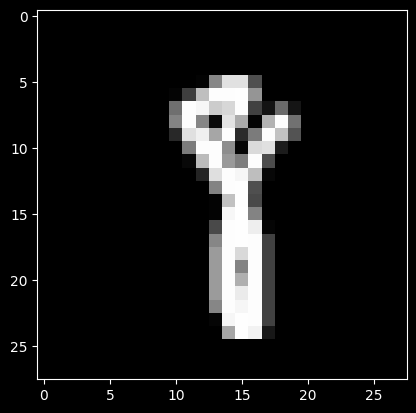

In [111]:
print(real_cf_idx)
real_cf = X[720]
# plt.imshow(explanation.cf['X'].reshape(28, 28))
plt.imshow(real_cf.reshape(28, 28));